This follows the tutorial from https://www.oreilly.com/learning/generative-adversarial-networks-for-beginners

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from tensorflow.examples.tutorials.mnist import input_data

In [3]:
mnist = input_data.read_data_sets('mnist/')

Extracting mnist/train-images-idx3-ubyte.gz
Extracting mnist/train-labels-idx1-ubyte.gz
Extracting mnist/t10k-images-idx3-ubyte.gz
Extracting mnist/t10k-labels-idx1-ubyte.gz


In [4]:
X_train_b, Y_train_b = mnist.train.next_batch(25)

## Helpers

In [134]:
def conv_layer(X, num_filters, num_input_channels, layer_num):
    """Creates and returns a convolutional layer by applying a 5x5 convolution, relu, then 2x2 max pooling"""
    w = tf.get_variable('d_w%d' % layer_num, [5, 5, num_input_channels, num_filters],
                        initializer = tf.truncated_normal_initializer(stddev=0.2))
    b = tf.get_variable('d_b%d' % layer_num, [num_filters], initializer = tf.constant_initializer(0))
    d = tf.nn.conv2d(X, w, strides=[1,1,1,1], padding='SAME') + b
    d = tf.nn.relu(d)
    d = tf.nn.avg_pool(d, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    return d

In [6]:
def fcl(X, input_size, num_neurons, layer_num):
    """Applies a fully connected layer, without the activation function"""
    w = tf.get_variable('d_w%d' % layer_num, [input_size, num_neurons], 
                           initializer=tf.truncated_normal_initializer(stddev=0.02))
    b = tf.get_variable('d_b%d' % layer_num, [num_neurons], initializer=tf.constant_initializer(0))
    d = tf.matmul(X, w) + b
    return d

## Discriminator / Generator

In [100]:
def discriminator(X, reuse=False):
    """TODO: Batch Norm or Local Response Normalization, because relu is unbounded"""
    if reuse:
        tf.get_variable_scope().reuse_variables()
    
    # 32 filters of 5x5 (shape = (?, 14, 14, 32)). Then 64 filters of 5x5 (shape = (?, 7, 7, 64))
    c0 = conv_layer(X, num_filters=32, num_input_channels=1, layer_num=0)
    c1 = conv_layer(c0, num_filters=64, num_input_channels=32, layer_num=1)
    
    # resizes to [batch_size, dim]
    c1 = tf.reshape(c1, [-1, 7*7*64])
    fc_0 = tf.nn.relu(fcl(c1, 7*7 *64, num_neurons=1024, layer_num=2))
    # TODO: why don't we sigmoid the last layer?
    fc_1 = fcl(fc_0, 1024, num_neurons=1, layer_num=3)
    
    return fc_1


In [126]:
def generator(U):
    """"""
    batch_size, dims = U.shape[0], U.shape[1]
    g_w0 = tf.get_variable('g_w0', [dims, 56*56], dtype=tf.float32, 
                           initializer=tf.truncated_normal_initializer(stddev=0.2))
    g_b0 = tf.get_variable('g_b0', [56*56], dtype=tf.float32, initializer=tf.constant_initializer(0))
    g0 = tf.matmul(U, g_w0) + g_b0
    g0 = tf.reshape(g0, [-1, 56, 56, 1])
    g0 = tf.nn.relu(g0)
    g0 = tf.contrib.layers.batch_norm(g0, epsilon=1e-5)
    
    # Generate 50 features using 3x3 convolution on the 56x56 image
    g_w1 = tf.get_variable('g_w1', [3, 3, 1, 50], dtype=tf.float32, 
                           initializer=tf.truncated_normal_initializer(stddev=0.2))
    g_b1 = tf.get_variable('g_b1', [50], dtype=tf.float32, initializer=tf.constant_initializer(0))
    g1 = tf.nn.conv2d(g0, g_w1, strides=[1,2,2,1], padding='SAME')
    g1 = g1 + g_b1
    g1 = tf.nn.relu(g1)  
    # g1.shape -> (?, 28, 28, 50)
    g1 = tf.contrib.layers.batch_norm(g1, epsilon=1e-5) 
    # uses bilinear interpolation to resize 28x28 -> 56x56
    g1 = tf.image.resize_images(g1, [56, 56])
    
    # Generate 25 features using 3x3 convolution on the 56x56 image
    g_w2 = tf.get_variable('g_w2', [3, 3, 50, 25], dtype=tf.float32, 
                           initializer=tf.truncated_normal_initializer(stddev=0.2))
    g_b2 = tf.get_variable('g_b2', [25], dtype=tf.float32, initializer=tf.constant_initializer(0))
    g2 = tf.nn.conv2d(g1, g_w2, strides=[1,2,2,1], padding='SAME')
    g2 = g2 + g_b2
    g2 = tf.nn.relu(g2)  
    # g1.shape -> (1, 28, 28, 50)
    g2 = tf.contrib.layers.batch_norm(g2, epsilon=1e-5) 
    # uses bilinear interpolation to resize 28x28 -> 56x56
    g2 = tf.image.resize_images(g2, [56, 56])
    
    # Final convolution with 1 output channel
    g_w3 = tf.get_variable('g_w3', [1, 1, 25, 1], dtype=tf.float32, 
                           initializer=tf.truncated_normal_initializer(stddev=0.2))
    g_b3 = tf.get_variable('g_b3', [1], dtype=tf.float32, initializer=tf.constant_initializer(0))
    g3 = tf.nn.conv2d(g2, g_w3, strides=[1,2,2,1], padding='SAME')
    g3 = g3 + g_b3
    g3 = tf.sigmoid(g3)
    
    return g3

## Computation Graph

In [127]:
tf.reset_default_graph()
U_placeholder = tf.placeholder(tf.float32, [None, 100])
X_placeholder = tf.placeholder(tf.float32, [None, 28, 28, 1])

with tf.variable_scope('gen_dis_scope'):
    Gu = generator(U_placeholder)
    Dx = discriminator(X_placeholder, reuse=False)
    # reuse same variables as Dx discriminator
    Dg = discriminator(Gu, reuse=True)

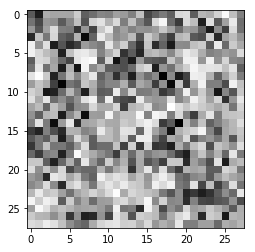

In [128]:
# Lets view a generated image...
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    U = np.random.normal(0, 1, [1, 100])
    gen_img = sess.run(Gu, feed_dict = {U_placeholder: U})
    gen_img = gen_img.reshape([28, 28])
    plt.imshow(gen_img, cmap='Greys')

In [129]:
# Loss functions
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dx, labels=tf.ones_like(Dx)))
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dg, labels=tf.zeros_like(Dg)))
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dg, labels=tf.ones_like(Dg)))

In [132]:
# Optimizers
trainable_vars = tf.trainable_variables()
d_vars = [var for var in trainable_vars if 'd_' in var.name]
g_vars = [var for var in trainable_vars if 'g_' in var.name]

print d_vars
print g_vars

# be careful, AdamOptimizer creates its own vars for memory, and could play poorly with reuse 
# (https://stackoverflow.com/questions/42603702/variable-scope-causes-variable-does-not-exist-with-optimizer)
d_optimizer = tf.train.AdamOptimizer(0.0003).minimize(d_loss_real + d_loss_fake, var_list=d_vars)
g_optimizer = tf.train.AdamOptimizer(0.00008).minimize(g_loss, var_list=g_vars)

[<tf.Variable 'gen_dis_scope/d_w0:0' shape=(5, 5, 1, 32) dtype=float32_ref>, <tf.Variable 'gen_dis_scope/d_b0:0' shape=(32,) dtype=float32_ref>, <tf.Variable 'gen_dis_scope/d_w1:0' shape=(5, 5, 32, 64) dtype=float32_ref>, <tf.Variable 'gen_dis_scope/d_b1:0' shape=(64,) dtype=float32_ref>, <tf.Variable 'gen_dis_scope/d_w2:0' shape=(3136, 1024) dtype=float32_ref>, <tf.Variable 'gen_dis_scope/d_b2:0' shape=(1024,) dtype=float32_ref>, <tf.Variable 'gen_dis_scope/d_w3:0' shape=(1024, 1) dtype=float32_ref>, <tf.Variable 'gen_dis_scope/d_b3:0' shape=(1,) dtype=float32_ref>]
[<tf.Variable 'gen_dis_scope/g_w0:0' shape=(100, 3136) dtype=float32_ref>, <tf.Variable 'gen_dis_scope/g_b0:0' shape=(3136,) dtype=float32_ref>, <tf.Variable 'gen_dis_scope/g_w1:0' shape=(3, 3, 1, 50) dtype=float32_ref>, <tf.Variable 'gen_dis_scope/g_b1:0' shape=(50,) dtype=float32_ref>, <tf.Variable 'gen_dis_scope/g_w2:0' shape=(3, 3, 50, 25) dtype=float32_ref>, <tf.Variable 'gen_dis_scope/g_b2:0' shape=(25,) dtype=float3

d:0 0.942208 0.42688
d:20 7.47666e-07 7.14225e-05
d:40 4.96985e-07 1.39211e-05
d:60 7.31814e-08 5.74395e-06
d:80 7.94868e-08 5.12393e-06
d:100 9.6627e-08 3.82756e-06
g:100 13.0512
d:120 7.6018e-07 4.69128e-06
g:120 13.0998
d:140 1.89417e-06 2.44416e-06
g:140 13.6091
d:160 2.46129e-08 2.25877e-06
g:160 13.3596
d:180 2.45904e-08 1.63601e-06
g:180 14.0473
d:200 1.17404e-07 1.55329e-06
g:200 13.6033
d:220 1.86912e-07 1.21512e-06
g:220 13.9415
d:240 3.38502e-07 9.1503e-07
g:240 14.1058
d:260 6.40708e-08 9.907e-07
g:260 14.3615
d:280 2.77675e-07 5.8853e-07
g:280 14.4211
d:300 2.26748e-08 5.61966e-07
g:300 14.903
d:320 2.41905e-08 5.59639e-07
g:320 14.6116
d:340 6.32673e-09 5.54981e-07
g:340 15.001
d:360 3.74343e-09 5.52438e-07
g:360 15.0402
d:380 4.74868e-08 5.61399e-07
g:380 15.4875
d:400 2.64293e-09 4.95917e-07
g:400 15.3218
d:420 5.63335e-08 2.14645e-07
g:420 15.3877
d:440 1.23877e-08 2.41021e-07
g:440 15.7966
d:460 1.24676e-09 2.68803e-07
g:460 15.8347
d:480 1.6797e-08 2.05948e-07
g:480 

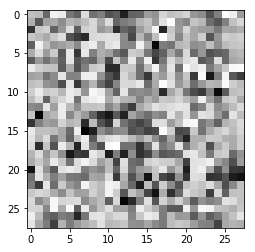

In [133]:
batch_size = 16
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    # Train discriminator a bit first.
    for i in range(1000):
        train_batch = mnist.train.next_batch(batch_size)
        x_train_batch = train_batch[0].reshape([-1,28,28,1])
        u_batch = np.random.normal(0, 1, [batch_size, 100])
        if i >= 0:
            _, d_loss_real_val, d_loss_fake_val = sess.run([d_optimizer, d_loss_real, d_loss_fake], 
                                                               feed_dict={X_placeholder: x_train_batch, U_placeholder: u_batch})
            if i % 20 == 0: print 'd:%d' % i, d_loss_real_val, d_loss_fake_val
        #print i, d_loss_fake_val
        if i >= 100:
            u_batch = np.random.normal(0, 1, [batch_size, 100])
            g_loss_val = sess.run(g_loss, feed_dict={U_placeholder: u_batch})
            if i % 20 == 0: print 'g:%d' % i, g_loss_val
            # show img every 5
            if i % 5 == 0:
                gen_imgs = sess.run(Gu, feed_dict={U_placeholder: u_batch})
                gen_img = gen_imgs[0].reshape([28,28])
                plt.imshow(gen_img, cmap='Greys')
        